### Imports

In [486]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from scipy.stats import norm
import math

### Read every cohort study file

In [487]:
datasets = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cohort_studies_full_data/' + "/*."+'csv'))]
cohorts = [file.split(".")[0] for file in sorted(os.listdir('../cohort_studies_full_data/'))]

In [488]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
# dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
#     dfsss[cohort_n] = dataset

In [489]:
datasets_sub = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../preprocessed_datasets/' + "/*."+'csv'))]
cohorts_sub = [file.split(".")[0] for file in sorted(os.listdir('../preprocessed_datasets/'))]

In [490]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies_sub = dict()

for cohort, dataset in zip(cohorts_sub, datasets_sub):
    cohort_studies_sub[cohort] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit

In [491]:
for i in cohort_studies:
    cohort_studies[i]['Age']=cohort_studies_sub[i]['Age']

### EMIF and NACC datasets have CSF measurements from two different assay methods

In [492]:
print(cohort_studies['NACC'].loc[cohort_studies['NACC']['CSFTTMD']==1].shape) # ELISA
print(cohort_studies['NACC'].loc[cohort_studies['NACC']['CSFTTMD']==2].shape) # xmap

(206, 1170)
(330, 1170)


In [493]:
print(cohort_studies['EMIF'].loc[(cohort_studies['EMIF']['Studyname'].isin(['EDAR', 'Leuven', ]))].shape) # xmap and not collected
print(cohort_studies['EMIF'].loc[~(cohort_studies['EMIF']['Studyname'].isin(['EDAR', 'Leuven', ]))].shape) # INNOTEST ELISA

(373, 128)
(826, 128)


### Read harmonized mapping tables

In [494]:
modality = [pd.read_csv(file, sep=',') for file in sorted(glob.glob('../feature_tables' + "/*."+'csv'))]
name = [file.split(".")[0] for file in sorted(os.listdir('../feature_tables'))]

In [495]:
# make a dictionary that contains all modalities as a dataframe
mappings = dict()

for moda, na in zip(modality, name):
    mappings[na.split(' - ')[1]] = moda

In [496]:
harmonized_features = pd.concat(mappings, ignore_index=True) # combine all tables

In [497]:
# exclude categorical and taboo features
harmonized_features = harmonized_features.loc[(harmonized_features['Rank']!=1) & (harmonized_features['Rank']!=2)]

### Read the feature availability files for all cohorts

In [498]:
ava_mapp = [pd.read_csv(file, sep='\t') for file in sorted(glob.glob('../feature_availability_in_cohorts' + "/*."+'tsv'))]
tablesss = [file.split(".")[0] for file in sorted(os.listdir('../feature_availability_in_cohorts'))]

In [499]:
# make a dictionary that contains all modalities as a dataframe
available_features = dict()

for modal, df in zip(tablesss, ava_mapp):
    available_features[modal] = df

In [500]:
existing_features = pd.concat(available_features, ignore_index=True) # combine all tables

In [501]:
existing_features.replace({0: np.nan}, inplace=True) # 0 indicates that the feature was not measured 

### Selecetion of cohort studies for A/T/N assignment

### Select the patient that have CSF biomarker, disregard the diagnostic status

In [502]:
atn = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=mappings['csf'].Feature.loc[0:2].to_list()+(["Total"]))
# atn = pd.DataFrame(index=cohort_studies, columns=['A', 'T', 'N'])

In [503]:
for cohort in atn.index:
    for feat in mappings['csf'][cohort].loc[0:2].dropna().to_list():
        if feat in cohort_studies[cohort].columns:
            atn.loc[cohort, mappings['csf'].loc[mappings['csf'][cohort]==feat, 'Feature']] = len(cohort_studies[cohort][feat].dropna())
            atn.loc[cohort, 'Total'] = len(cohort_studies[cohort][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [504]:
# atn

In [505]:
diag = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=cohort_studies['ADNI']['Diagnosis'].dropna().unique())

In [506]:
for cohort in diag.index:
    for dia in diag.columns:
        diag.loc[cohort, dia] = len(cohort_studies[cohort].loc[cohort_studies[cohort]['Diagnosis']==dia][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [507]:
# diag

### Remove the empty columns from all cohorts that we are intrested in
### Remove the participant without all 3 CSF biomarkers

In [508]:
selected_cohorts = dict()

for coh in diag.index:
    selected_cohorts[coh] = cohort_studies[coh].dropna(axis=1, how='all')

In [509]:
total_feats = dict()

# existing_features.set_index('Feature', inplace=True)

for feat in existing_features.Feature:
    total_feats[feat] = existing_features.loc[existing_features.Feature==feat][selected_cohorts].dropna(axis=1).columns

In [510]:
for cohort in atn.index:
    feat = mappings['csf'][cohort].loc[0:2].dropna().to_list()
    cohort_studies[cohort] = cohort_studies[cohort].dropna(subset=feat)

As Some features have suffix due to merging tables for certain cohorts, first investigate if all the harmonized features are in cohorts. Rename the ones that have suffix so it can be compatible to work with our harmonized names.

In [511]:
cohort_studies['ADNI'].rename(columns={'PTEDUCAT_x': 'PTEDUCAT', 'TRABSCOR_bl': 'TRABSCOR'}, inplace=True)

# Plot the CSF biomarkers in different cohorts

In [512]:
# fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
# fig.subplots_adjust(hspace=0.7)
# i=0

# for ind in atn.index:
#     csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
#     for bioma, colo in zip(csf, colors):
# #         print(bioma, csf.index(bioma))
#         sns.histplot(cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
# #         axes[i, csf.index(bioma)].set_title(bioma.upper())
#         axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
#     i+=1
    
# # plt.savefig("csf_biomarkers.png", dpi=300)

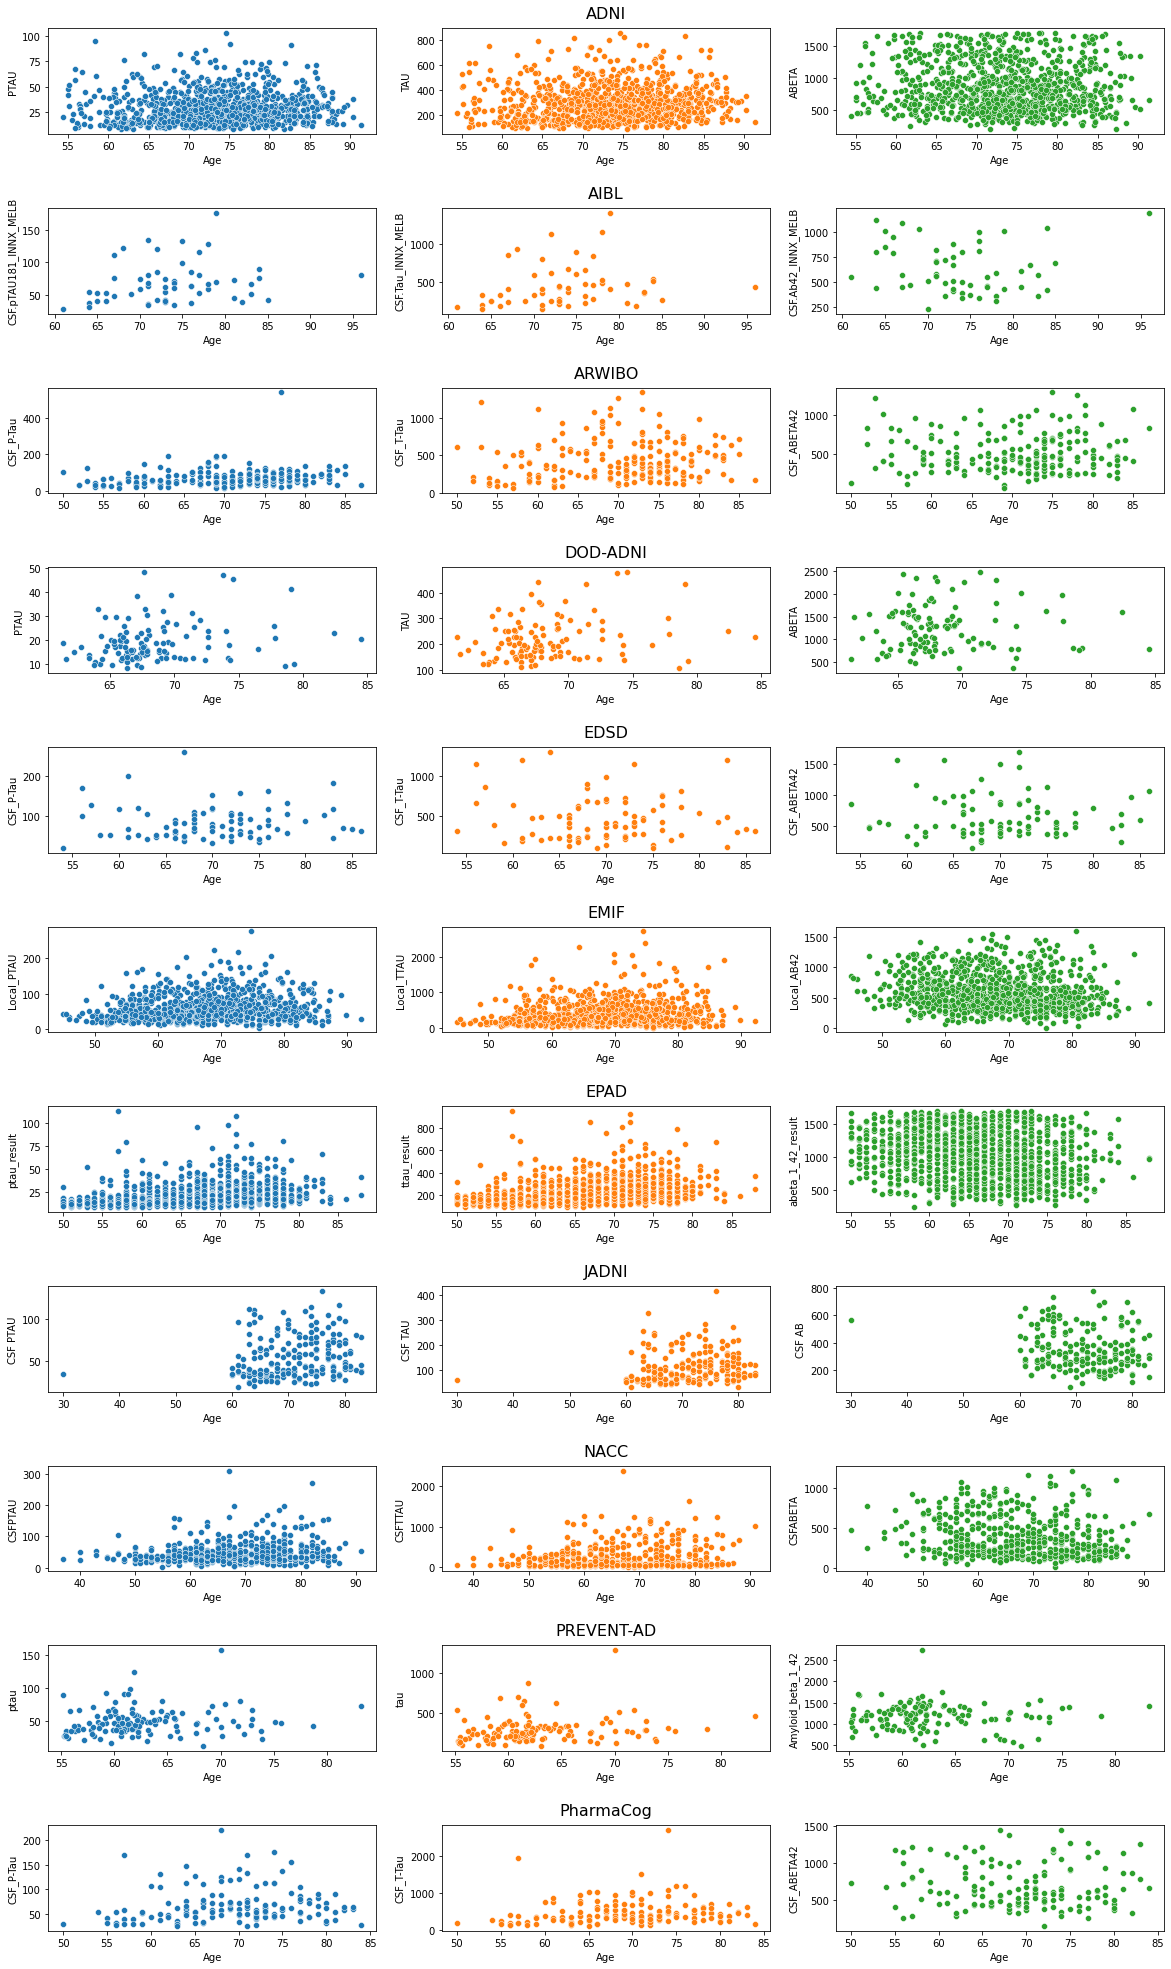

In [513]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in atn.index:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, colo in zip(csf, colors):
#         print(bioma, csf.index(bioma))
        sns.scatterplot(x=cohort_studies[ind]['Age'], y=cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
#         axes[i, csf.index(bioma)].set_title(bioma.upper())
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1
    
# plt.savefig("csf_biomarkers.png", dpi=300)

### Clustering CSF biomarkers, two classes, normal vs abnormal

### subset each cohort dataset based on the columns of interest for clustering 

In [514]:
atn.index

Index(['ADNI', 'AIBL', 'ARWIBO', 'DOD-ADNI', 'EDSD', 'EMIF', 'EPAD', 'JADNI',
       'NACC', 'PREVENT-AD', 'PharmaCog'],
      dtype='object')

In [515]:
cohorts_csf = dict()

for i in atn.index:
    csf = mappings['csf'].iloc[:3][i].to_list()
    
    if i == 'NACC':
        cohorts_csf['NACC_ELISA'] = cohort_studies[i].loc[cohort_studies[i]['CSFTTMD']==1][csf + ["Diagnosis", "Age"]] # ELISA
        cohorts_csf['NACC_XMAP'] = cohort_studies[i].loc[cohort_studies[i]['CSFTTMD']==2][csf + ["Diagnosis", "Age"]] # xmap
        cohorts_csf['NACC_ELISA'] = cohorts_csf['NACC_ELISA'].dropna(subset=cohorts_csf['NACC_ELISA'].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)
        cohorts_csf['NACC_XMAP'] = cohorts_csf['NACC_XMAP'].dropna(subset=cohorts_csf['NACC_XMAP'].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)

    
    elif i == 'EMIF':
        cohorts_csf['EMIF_ELISA'] = cohort_studies[i].loc[~(cohort_studies[i]['Studyname'].isin(['EDAR', 'Leuven', ]))][csf + ["Diagnosis", "Age"]] # INNOTEST ELISA
        cohorts_csf['EMIF_XMAP'] = cohort_studies[i].loc[(cohort_studies[i]['Studyname'].isin(['EDAR', 'Leuven', ]))][csf + ["Diagnosis", "Age"]] # xmap and not collected
        cohorts_csf['EMIF_ELISA'] = cohorts_csf['EMIF_ELISA'].dropna(subset=cohorts_csf['EMIF_ELISA'].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)
        cohorts_csf['EMIF_XMAP'] = cohorts_csf['EMIF_XMAP'].dropna(subset=cohorts_csf['EMIF_XMAP'].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)

    else: 
        cohorts_csf[i] = cohort_studies[i][csf + ["Diagnosis", "Age"]]
        cohorts_csf[i] = cohorts_csf[i].dropna(subset=cohorts_csf[i].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)

In [516]:
cohorts_csf.keys()

dict_keys(['ADNI', 'AIBL', 'ARWIBO', 'DOD-ADNI', 'EDSD', 'EMIF_ELISA', 'EMIF_XMAP', 'EPAD', 'JADNI', 'NACC_ELISA', 'NACC_XMAP', 'PREVENT-AD', 'PharmaCog'])

In [517]:
cohorts_csf['EMIF_XMAP'].shape

(203, 5)

# Gaussian Mixture Model (GMM)

### Scale CSF Features

In [518]:
# scale each feature and write it as a new column in the respective dataframe
# name the new columns with a suffix "_scaled"
for cohort in cohorts_csf:
    
    for i in cohorts_csf[cohort].columns.difference(['Diagnosis']): 
        cohorts_csf[cohort][i + '_scaled'] = MinMaxScaler().fit_transform(X=cohorts_csf[cohort][[i]])

In [519]:
for i in cohorts_csf:
    if len(cohorts_csf[i][cohorts_csf[i].columns[1]]) != len(cohorts_csf[i]['Age_scaled'].dropna()):
        print(i)

### GMM Training

In [520]:
hypersss = dict()
scoresss = dict()
silhouette = dict()

for i in cohorts_csf:
#     print(i)
    # Create empty dictionary for storing hyperparameters (number of clusters)
    hyper = dict()

    # Create empty dictionary for storing BIC scores
    scores = dict()

    # Create empty dictionary for storing silhouette scores
    sil_scores = dict()

    # Define different number of clusters to explore
    n_clus = range(2, 5, 1) 
    
    if '_' not in i:

        for biom in [x + "_scaled" for x in mappings['csf'].iloc[:3][i].to_list()]:

            clus = list()
            bic_ = list()
            sil = list()

            for n in n_clus:

                # Set the model and its parameter
                model = GaussianMixture(n_components=n, n_init=20)
                # Fit the model 
                clm = model.fit(cohorts_csf[i][biom].values.reshape(-1,1))
                lables = clm.predict(cohorts_csf[i][biom].values.reshape(-1,1))

                # Calculate BIC Scores and silhouette scores then store them in a dictionaries
                clus.append(n)
                bic_.append(clm.bic(cohorts_csf[i][biom].values.reshape(-1,1))) # BIC scores
                sil.append(metrics.silhouette_score(cohorts_csf[i][biom].values.reshape(-1,1), lables))

            hyper[biom] = clus
            scores[biom] = bic_
            sil_scores[biom] = sil

        hypersss[i] = hyper
        scoresss[i] = scores
        silhouette[i] = sil_scores
        
        
    else:
        j = i.split("_")[0] # actual cohort name 

        for biom in [x + "_scaled" for x in mappings['csf'].iloc[:3][j].to_list()]:

            clus = list()
            bic_ = list()
            sil = list()

            for n in n_clus:

                # Set the model and its parameter
                model = GaussianMixture(n_components=n, n_init=20)
                # Fit the model 
                clm = model.fit(cohorts_csf[i][biom].values.reshape(-1,1))
                lables = clm.predict(cohorts_csf[i][biom].values.reshape(-1,1))

                # Calculate BIC Scores and silhouette scores then store them in a dictionaries
                clus.append(n)
                bic_.append(clm.bic(cohorts_csf[i][biom].values.reshape(-1,1))) # BIC scores
                sil.append(metrics.silhouette_score(cohorts_csf[i][biom].values.reshape(-1,1), lables))

            hyper[biom] = clus
            scores[biom] = bic_
            sil_scores[biom] = sil

        hypersss[i] = hyper
        scoresss[i] = scores
        silhouette[i] = sil_scores

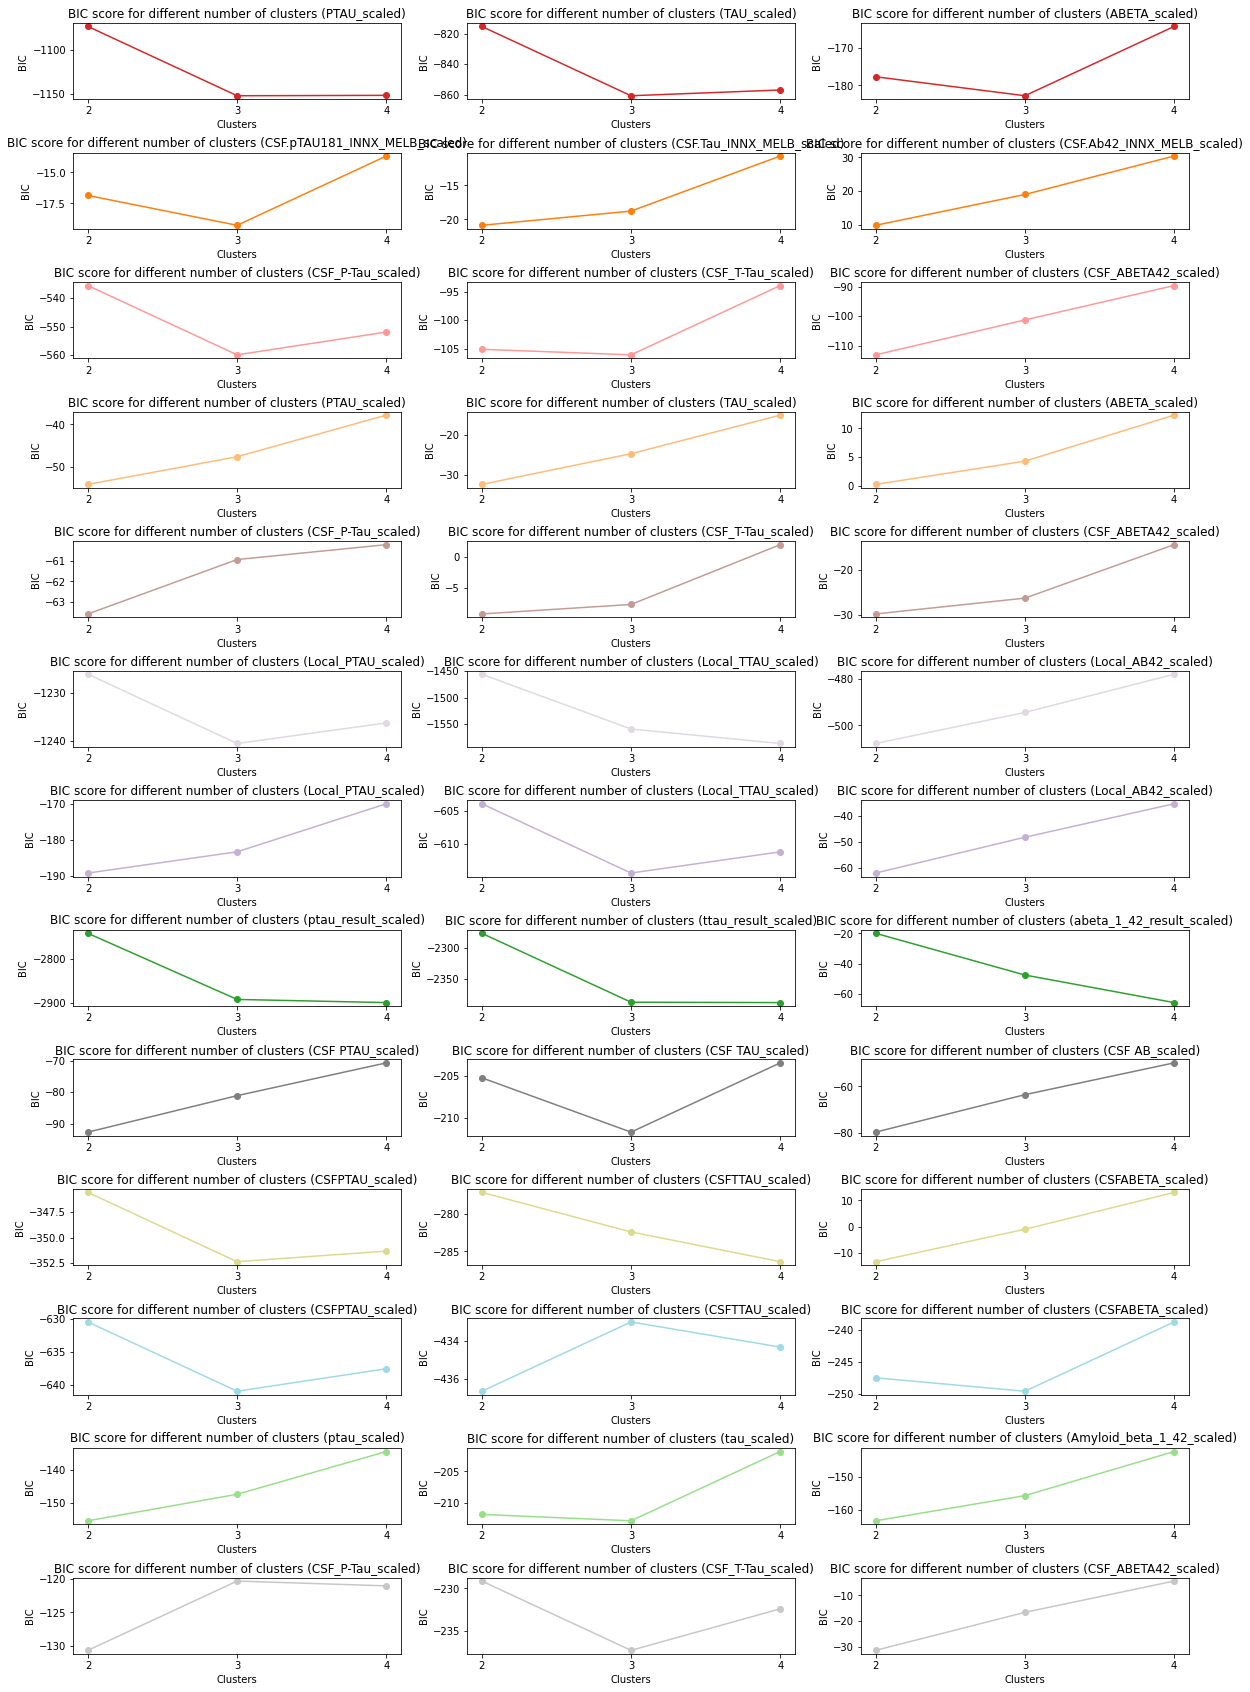

In [521]:
colors = {'ADNI': '#d62728', 'ANM': '#1f77b4', 'AIBL': '#ff7f0e', 'EPAD': '#2ca02c', 
          'NACC': '#9467bd', 'EMIF': '#8c564b', 'ROSMAP': '#e377c2', 'JADNI': '#7f7f7f', 
          'A4': '#aec7e8', 'DOD-ADNI': '#ffbb78', 'PREVENT-AD': '#98df8a', 'ARWIBO': '#ff9896', 
          'EMIF_XMAP': '#c5b0d5', 'EDSD': '#c49c94', 'OASIS': '#f7b6d2', 'PharmaCog': '#c7c7c7', 
          'VITA': '#bcbd22', 'NACC_ELISA': '#dbdb8d', 'NACC_XMAP': '#9edae5', 'EMIF_ELISA': '#e0d9e2'}

fig, axes = plt.subplots(len(hypersss.keys()), 3, sharex=False, figsize=(20, 30))
fig.subplots_adjust(hspace=0.7)
ind=0

for cohort in hypersss:
    
    for i in hypersss[cohort]:
        # Plot the resulting BIC scores on a graph
        axes[ind, list(hypersss[cohort].keys()).index(i)].plot(hypersss[cohort][i], scoresss[cohort][i], 'o-', color=colors[cohort])
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_xlabel('Clusters')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_ylabel('BIC')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_title(f'BIC score for different number of clusters ({i})')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_xticks(hypersss[cohort][i])
    ind+=1

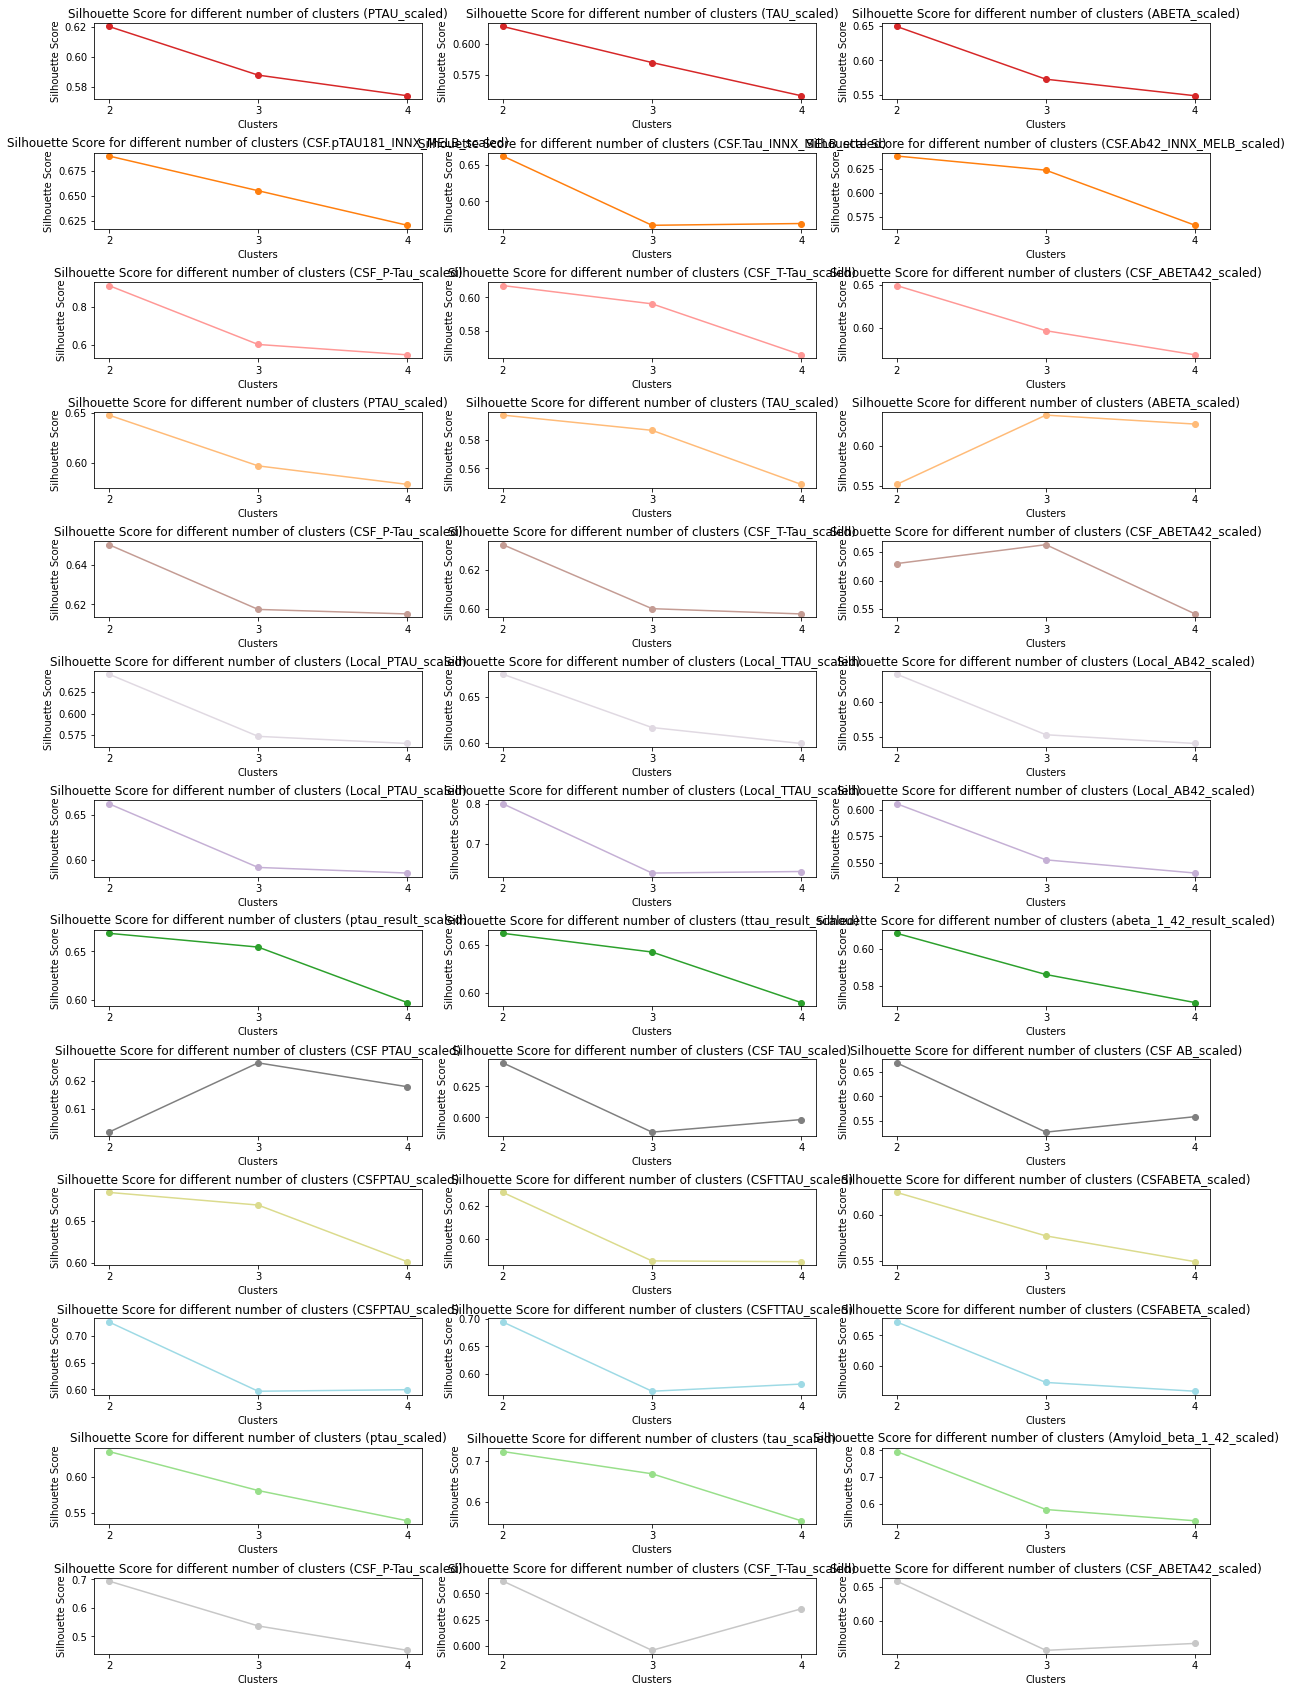

In [522]:
fig, axes = plt.subplots(len(hypersss.keys()), 3, sharex=False, figsize=(20, 30))
fig.subplots_adjust(hspace=0.7)
ind=0

for cohort in hypersss:
    
    for i in hypersss[cohort]:
        # Plot the resulting BIC scores on a graph
        axes[ind, list(hypersss[cohort].keys()).index(i)].plot(hypersss[cohort][i], silhouette[cohort][i], 'o-', color=colors[cohort])
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_xlabel('Clusters')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_ylabel('Silhouette Score')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_title(f'Silhouette Score for different number of clusters ({i})')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_xticks(hypersss[cohort][i])
    ind+=1

### Save all BIC scores and number of clusters into dataframes for each cohort

In [523]:
score_hyper_dfs = dict()

for i in scoresss:
    for bio in scoresss[i]:
        score_df = pd.DataFrame.from_dict(scoresss[i], orient='index').transpose()
        score_df.columns = [x + '_score' for x in  score_df.columns]
        hyper_df = pd.DataFrame.from_dict(hypersss[i], orient='index').transpose()
        hyper_df.columns = [x + '_hyper' for x in  hyper_df.columns]
        score_hyper_dfs[i] = pd.concat([score_df, hyper_df], axis=1)

In [524]:
[col.split('_')[0] for col in score_hyper_dfs['ADNI'].columns[:3]]

['PTAU', 'TAU', 'ABETA']

In [525]:
my_cols = list()

for prefix in ['mean1_', 'mean2_', 'var1_', 'var2_']:
    
    for i in mappings['csf']['Feature'][:3].to_list():
        my_cols.append(prefix + i)
        
# make an empty df to save the mean and covariances        
mean_variances_df = pd.DataFrame(index=cohorts_csf.keys(), columns=my_cols)

In [526]:
score_hyper_dfs['NACC_ELISA']

,CSFPTAU_scaled_score,CSFTTAU_scaled_score,CSFABETA_scaled_score,CSFPTAU_scaled_hyper,CSFTTAU_scaled_hyper,CSFABETA_scaled_hyper
0,-345.608951,-277.212397,-13.247765,2,2,2
1,-352.354605,-282.431357,-0.952488,3,3,3
2,-351.324284,-286.361120,13.013720,4,4,4


In [527]:
for cname in score_hyper_dfs:
    
    if '_' not in cname:

        for col in score_hyper_dfs[cname].columns:

            if '_score' in col:
                hypers_ = col.split('_score')[0] + '_hyper' 
                n_clus = score_hyper_dfs[cname].loc[score_hyper_dfs[cname][col] == np.min(score_hyper_dfs[cname][col]), hypers_].iloc[0]
                variable = mappings['csf'].loc[mappings['csf'][cname]==col.split('_scaled_score')[0], 'Feature'].item()

                # Set the model and its parameters
    #             model = GaussianMixture(n_components=n_clus)
                model = GaussianMixture(n_components=2, n_init=20)

                # Fit the model 
                clm = model.fit(cohorts_csf[cname][col.split('_score')[0]].values.reshape(-1,1))
                # extract the mean and std of each Gaussian
                mean_variances_df.loc[cname, 'mean1_' + variable] = clm.means_.tolist()[0][0]
                mean_variances_df.loc[cname, 'mean2_' + variable] = clm.means_.tolist()[1][0]
                # note: we can extract the covariance matrix where the diagonal elements are variance
                # square root of variance will result in std
                mean_variances_df.loc[cname, 'var1_' + variable] = math.sqrt(clm.covariances_.tolist()[0][0][0])
                mean_variances_df.loc[cname, 'var2_' + variable] = math.sqrt(clm.covariances_.tolist()[1][0][0])

                cohorts_csf[cname][str(col.split('_scaled_score')[0]) + "_ATN"] = clm.predict(cohorts_csf[cname][col.split('_score')[0]].values.reshape(-1,1))
                prob0 = clm.predict_proba(cohorts_csf[cname][col.split('_score')[0]].values.reshape(-1,1))[:,0]
                prob1 = clm.predict_proba(cohorts_csf[cname][col.split('_score')[0]].values.reshape(-1,1))[:,1]
                cohorts_csf[cname][str(col.split('_scaled_score')[0]) + "_ATN_probab_0"], cohorts_csf[cname][str(col.split('_scaled_score')[0]) + "_ATN_probab_1"] = prob0, prob1
                
    else:
        cname_new = cname.split("_")[0]
        
        for col in score_hyper_dfs[cname].columns:

            if '_score' in col:
                hypers_ = col.split('_score')[0] + '_hyper' 
                n_clus = score_hyper_dfs[cname].loc[score_hyper_dfs[cname][col] == np.min(score_hyper_dfs[cname][col]), hypers_].iloc[0]
                variable = mappings['csf'].loc[mappings['csf'][cname_new]==col.split('_scaled_score')[0], 'Feature'].item()

                # Set the model and its parameters
            #             model = GaussianMixture(n_components=n_clus)
                model = GaussianMixture(n_components=2, n_init=20)

                # Fit the model 
                clm = model.fit(cohorts_csf[cname][col.split('_score')[0]].values.reshape(-1,1))
                # extract the mean and std of each Gaussian
                mean_variances_df.loc[cname, 'mean1_' + variable] = clm.means_.tolist()[0][0]
                mean_variances_df.loc[cname, 'mean2_' + variable] = clm.means_.tolist()[1][0]
                # note: we can extract the covariance matrix where the diagonal elements are variance
                # square root of variance will result in std
                mean_variances_df.loc[cname, 'var1_' + variable] = math.sqrt(clm.covariances_.tolist()[0][0][0])
                mean_variances_df.loc[cname, 'var2_' + variable] = math.sqrt(clm.covariances_.tolist()[1][0][0])

                cohorts_csf[cname][str(col.split('_scaled_score')[0]) + "_ATN"] = clm.predict(cohorts_csf[cname][col.split('_score')[0]].values.reshape(-1,1))
                prob0 = clm.predict_proba(cohorts_csf[cname][col.split('_score')[0]].values.reshape(-1,1))[:,0]
                prob1 = clm.predict_proba(cohorts_csf[cname][col.split('_score')[0]].values.reshape(-1,1))[:,1]
                cohorts_csf[cname][str(col.split('_scaled_score')[0]) + "_ATN_probab_0"], cohorts_csf[cname][str(col.split('_scaled_score')[0]) + "_ATN_probab_1"] = prob0, prob1


In [528]:
mean_variances_df

,mean1_pTau in CSF,mean1_tTau in CSF,mean1_A-beta 1-42 in CSF,mean2_pTau in CSF,mean2_tTau in CSF,mean2_A-beta 1-42 in CSF,var1_pTau in CSF,var1_tTau in CSF,var1_A-beta 1-42 in CSF,var2_pTau in CSF,var2_tTau in CSF,var2_A-beta 1-42 in CSF
ADNI,0.138055,0.439836,0.736308,0.37849,0.177373,0.298433,0.082237,0.179817,0.157726,0.165413,0.093326,0.127506
AIBL,0.194283,0.142935,0.64704,0.64803,0.522139,0.236409,0.11368,0.095449,0.182391,0.155927,0.224453,0.103823
ARWIBO,0.105473,0.170824,0.25391,1.0,0.460102,0.568566,0.065701,0.091945,0.093595,0.001,0.194767,0.165398
DOD-ADNI,0.524515,0.199209,0.201298,0.185212,0.509361,0.52658,0.22351,0.108658,0.080551,0.10274,0.226723,0.20744
EDSD,0.489331,0.175055,0.194641,0.208895,0.525016,0.495325,0.212705,0.107029,0.072445,0.102394,0.224173,0.215186
EMIF_ELISA,0.149935,0.103903,0.24847,0.356622,0.303776,0.576683,0.068317,0.057562,0.099442,0.148735,0.162361,0.149888
EMIF_XMAP,0.521566,0.073394,0.31087,0.21845,0.317057,0.615209,0.201233,0.036877,0.117125,0.096163,0.230397,0.13974
EPAD,0.065685,0.095705,0.356519,0.232044,0.282123,0.758653,0.036563,0.046955,0.152846,0.141923,0.151619,0.140017
JADNI,0.453375,0.130412,0.286689,0.143657,0.379953,0.675152,0.186786,0.072864,0.108595,0.05817,0.164769,0.126927
NACC_ELISA,0.093849,0.29234,0.603938,0.314469,0.099555,0.223872,0.055301,0.149388,0.155831,0.169151,0.055216,0.114871


In [529]:
def reverse_standardization(dfs, cccs, csf_mappings):
    """
    dfs: a dictionary of dataframes where each df containes all CSF measurements, scaled CSF, etc. 
    cccs: df containing each cluster mean and SD for all CSF biomarkers
    csf_mappings: harmonized mapping of CSF biomarkers among the investigated cohorts
    """
    
    for study in dfs:
        
        if '_' not in study:
        
            for biomarker in csf_mappings['csf'].iloc[:3][study].to_list():

                min_, max_ = np.min(dfs[study][biomarker]), np.max(dfs[study][biomarker])
                featu = csf_mappings['csf'].loc[csf_mappings['csf'][study]==biomarker, 'Feature'].item()

                for prefix in ['mean1_', 'mean2_', 'var1_', 'var2_']:
    #                 print(cccs.loc[study][prefix + featu])
                    cccs.loc[study, prefix + featu + "_rs"]= round(cccs.loc[study][prefix + featu] * (max_ - min_) + min_, 2)

        else:
            study_n = study.split("_")[0]
            
            for biomarker in csf_mappings['csf'].iloc[:3][study_n].to_list():

                min_, max_ = np.min(dfs[study][biomarker]), np.max(dfs[study][biomarker])
                featu = csf_mappings['csf'].loc[csf_mappings['csf'][study_n]==biomarker, 'Feature'].item()

                for prefix in ['mean1_', 'mean2_', 'var1_', 'var2_']:
        #                 print(cccs.loc[study][prefix + featu])
                    cccs.loc[study, prefix + featu + "_rs"]= round(cccs.loc[study][prefix + featu] * (max_ - min_) + min_, 2)

        
    return cccs

In [530]:
reverse_standardization(cohorts_csf, mean_variances_df, mappings)

,mean1_pTau in CSF,mean1_tTau in CSF,mean1_A-beta 1-42 in CSF,mean2_pTau in CSF,mean2_tTau in CSF,mean2_A-beta 1-42 in CSF,var1_pTau in CSF,var1_tTau in CSF,var1_A-beta 1-42 in CSF,var2_pTau in CSF,...,var1_pTau in CSF_rs,var2_pTau in CSF_rs,mean1_tTau in CSF_rs,mean2_tTau in CSF_rs,var1_tTau in CSF_rs,var2_tTau in CSF_rs,mean1_A-beta 1-42 in CSF_rs,mean2_A-beta 1-42 in CSF_rs,var1_A-beta 1-42 in CSF_rs,var2_A-beta 1-42 in CSF_rs
ADNI,0.138055,0.439836,0.736308,0.37849,0.177373,0.298433,0.082237,0.179817,0.157726,0.165413,...,16.01,23.89,424.33,224.05,225.91,159.91,1303.04,648.86,438.64,393.49
AIBL,0.194283,0.142935,0.64704,0.64803,0.522139,0.236409,0.11368,0.095449,0.182391,0.155927,...,45.72,51.93,318.73,807.47,257.53,423.80,856.49,458.26,405.88,329.69
ARWIBO,0.105473,0.170824,0.25391,1.0,0.460102,0.568566,0.065701,0.091945,0.093595,0.001,...,48.98,15.13,279.42,646.71,179.27,309.82,375.85,761.21,179.51,267.45
DOD-ADNI,0.524515,0.199209,0.201298,0.185212,0.509361,0.52658,0.22351,0.108658,0.080551,0.10274,...,17.21,12.34,180.70,297.01,146.75,191.02,791.93,1476.98,537.64,804.87
EDSD,0.489331,0.175055,0.194641,0.208895,0.525016,0.495325,0.212705,0.107029,0.072445,0.102394,...,71.05,44.57,310.07,730.02,228.44,369.01,443.42,913.69,252.30,475.55
EMIF_ELISA,0.149935,0.103903,0.24847,0.356622,0.303776,0.576683,0.068317,0.057562,0.099442,0.148735,...,31.02,51.91,319.72,855.54,195.48,476.43,493.89,969.97,277.72,350.89
EMIF_XMAP,0.521566,0.073394,0.31087,0.21845,0.317057,0.615209,0.201233,0.036877,0.117125,0.096163,...,29.09,16.61,104.50,436.44,54.76,318.39,248.33,481.38,99.96,117.28
EPAD,0.065685,0.095705,0.356519,0.232044,0.282123,0.758653,0.036563,0.046955,0.152846,0.141923,...,11.83,22.87,177.34,336.15,135.81,224.97,761.48,1348.00,464.43,445.71
JADNI,0.453375,0.130412,0.286689,0.143657,0.379953,0.675152,0.186786,0.072864,0.108595,0.05817,...,40.83,26.05,84.18,179.65,62.17,97.33,277.06,549.43,152.19,165.05
NACC_ELISA,0.093849,0.29234,0.603938,0.314469,0.099555,0.223872,0.055301,0.149388,0.155831,0.169151,...,33.84,67.27,751.76,304.81,420.34,202.01,786.19,371.83,297.65,252.99


In [531]:
mean_sd_df = mean_variances_df[[col for col in mean_variances_df.columns if '_rs' in col]]

### plot all probabilistic clusters for each biomarker in each cohort

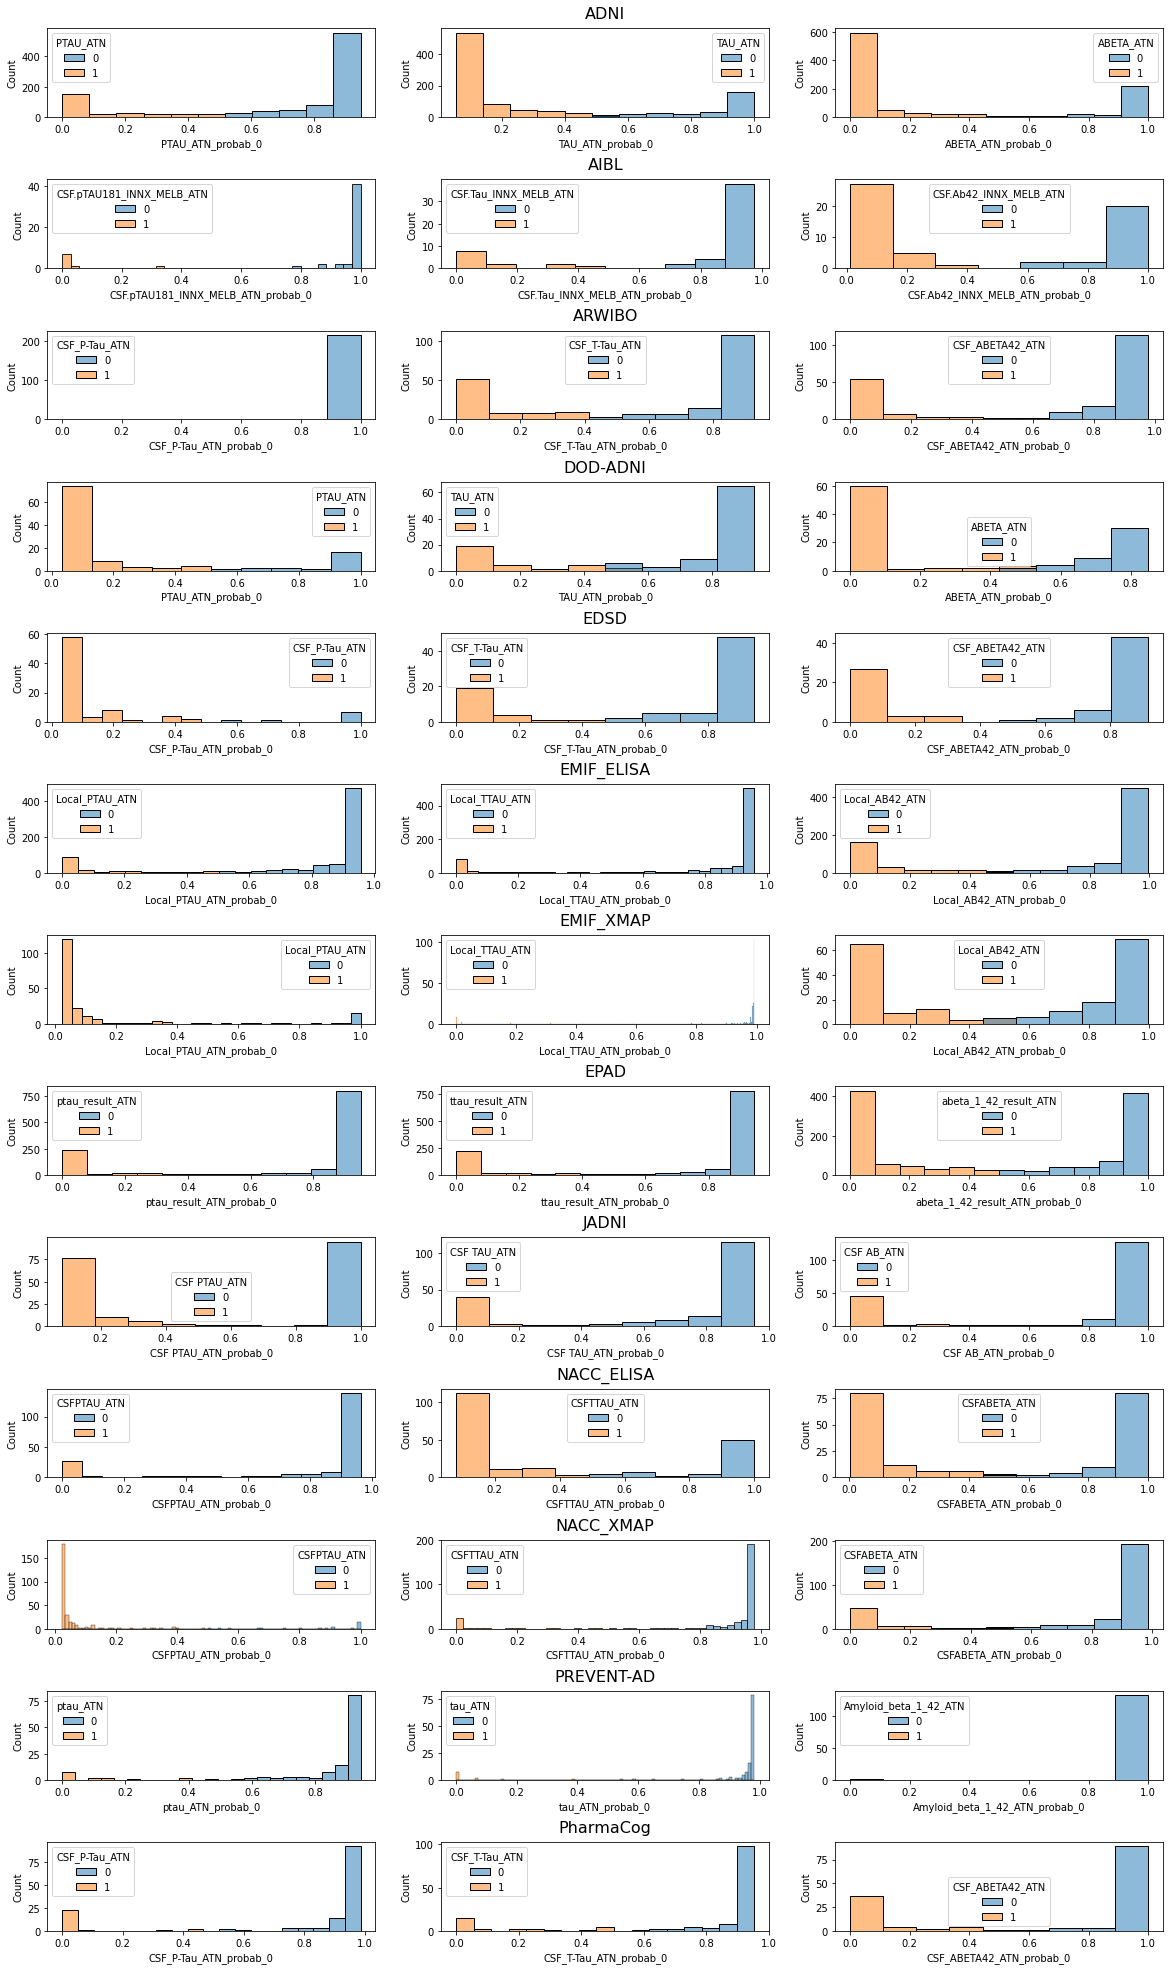

In [533]:
fig, axes = plt.subplots(len(cohorts_csf), 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in cohorts_csf:
    
    if '_' not in ind:
        csf = mappings['csf'].iloc[:3][ind].to_list()
    #     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    else:
        csf = mappings['csf'].iloc[:3][ind.split('_')[0]].to_list()
        
    colors = {0:'#2671bd', 1: '#87a8c9'}
    
    for bioma in csf:
#         sns.scatterplot(y=cohorts_csf[ind][bioma + '_ATN_probab_0'], x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"])
#         sns.scatterplot(y=cohorts_csf[ind][bioma + '_ATN_probab_1'], x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], color='r')

        sns.histplot(x=round(cohorts_csf[ind][bioma + '_ATN_probab_0'], 3), ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"], color=colors)
#         sns.histplot(round(cohorts_csf[ind][bioma + '_ATN_probab_1'], 3), ax=axes[i, csf.index(bioma)], color='b')

        
#         axes[i, csf.index(bioma)].set_title(bioma.upper())
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
        
    i+=1
    
# plt.savefig("csf_biomarkers_cluster.png", dpi=300)

### plot all clusters for each biomarker in each cohort

In [534]:
def solve(m1, m2, std1, std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

/home/ysalimi/.local/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/ysalimi/.local/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


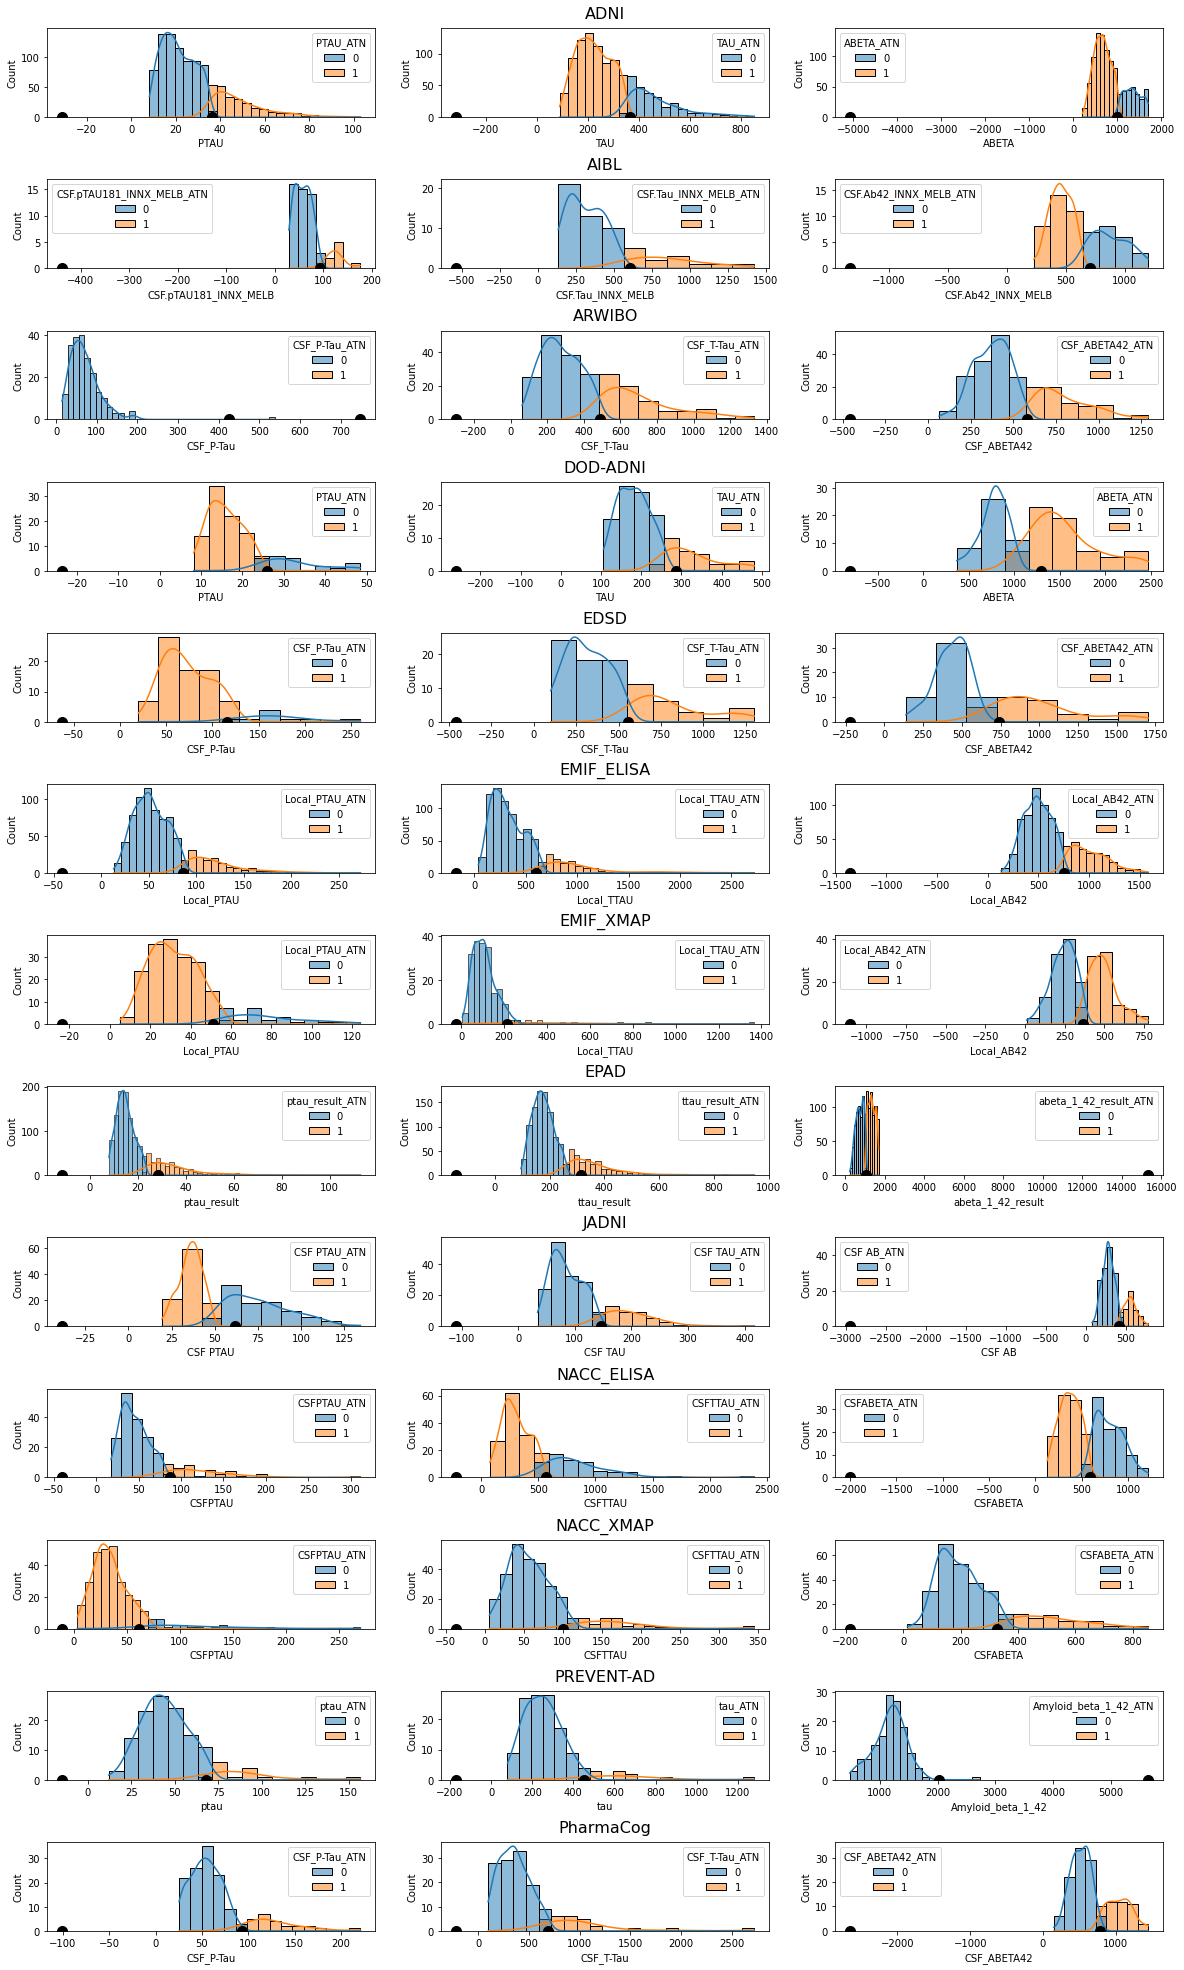

In [535]:
fig, axes = plt.subplots(len(cohorts_csf), 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in cohorts_csf:
    
    if '_' not in ind:
        csf = mappings['csf'].iloc[:3][ind].to_list()
        
    else:
        csf = mappings['csf'].iloc[:3][ind.split('_')[0]].to_list()
    
    csf_harmon = mappings['csf'].iloc[:3]['Feature'].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, bioma_har in zip(csf, csf_harmon):
        sns.histplot(x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"], kde=True)
        m11, std11 = mean_sd_df.loc[ind][['mean1_'+ bioma_har + '_rs', 'var1_'+ bioma_har + '_rs']]
        m22, std22 = mean_sd_df.loc[ind][['mean2_'+ bioma_har + '_rs', 'var2_'+ bioma_har + '_rs']]
        result = solve(m11, m22, std11, std22)
        axes[i, csf.index(bioma)].plot(result, norm.pdf(result,m11,std11),'o', markersize=10, color='black')
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1

In [536]:
cutpointssss_GMM = pd.DataFrame(index=cohorts_csf.keys(), columns=mappings['csf'].iloc[:3]['Feature'].to_list())
cutpointssss = pd.DataFrame(index=cohorts_csf.keys(), columns=mappings['csf'].iloc[:3]['Feature'].to_list())

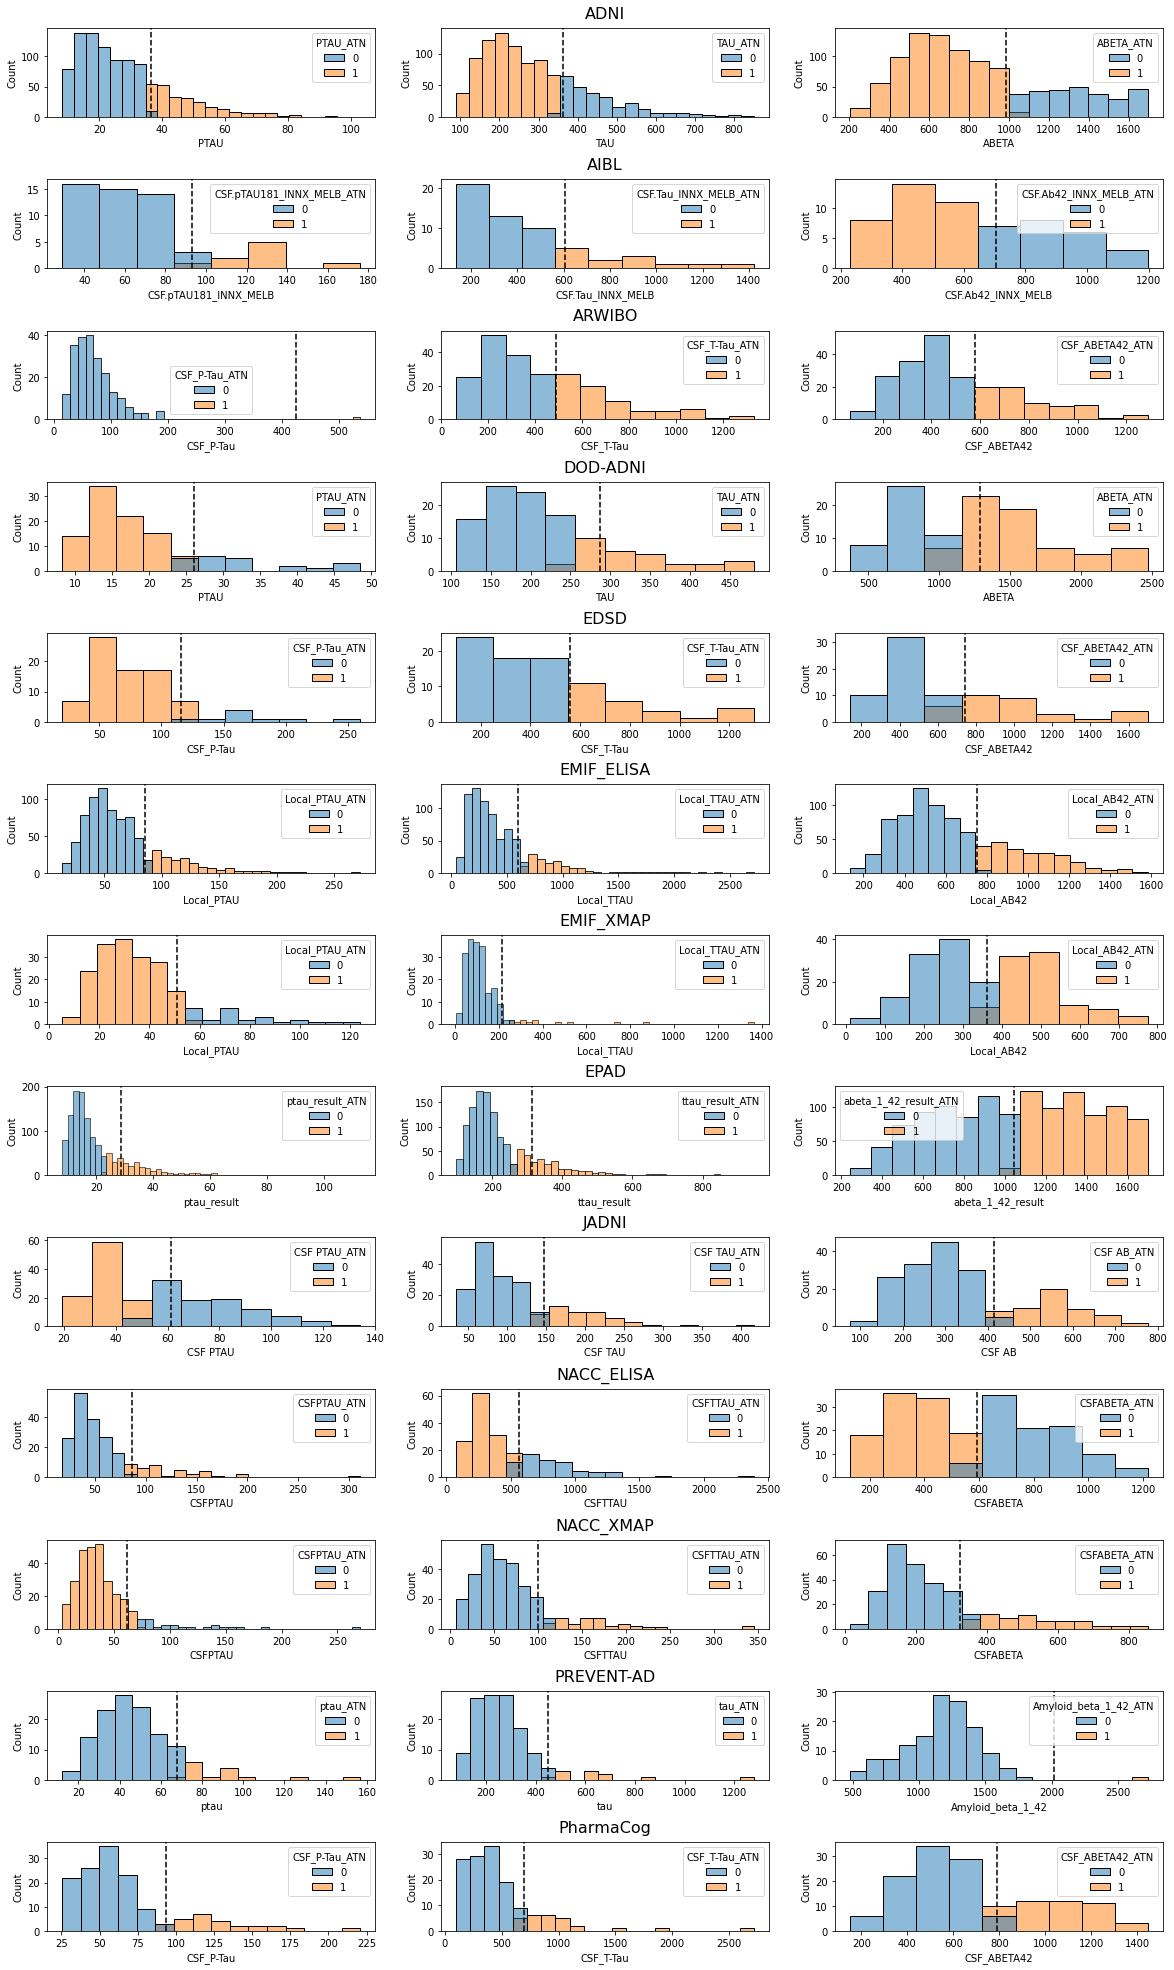

In [537]:
fig, axes = plt.subplots(len(cohorts_csf), 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in cohorts_csf:
    
    if "_" not in ind:
        csf = mappings['csf'].iloc[:3][ind].to_list()
        csf_harmon = mappings['csf'].iloc[:3]['Feature'].to_list()
        
        for bioma, bioma_har in zip(csf, csf_harmon):

            m11, std11 = mean_sd_df.loc[ind][['mean1_'+ bioma_har + '_rs', 'var1_'+ bioma_har + '_rs']]
            m22, std22 = mean_sd_df.loc[ind][['mean2_'+ bioma_har + '_rs', 'var2_'+ bioma_har + '_rs']]
            result = solve(m11, m22, std11, std22)
            cutpointssss_GMM.loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature']] = round(result[np.argmax(norm.pdf(result, m11, std11))], 2)
            axes[i, csf.index(bioma)].axvline(x=cutpointssss_GMM.loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature'].item()], c='black', ls='--') 

            # Plot the histogram.
    #         axes[i, csf.index(bioma)].hist(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==0, bioma], density=True, alpha=0.6, color='b')
    #         axes[i, csf.index(bioma)].hist(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==1, bioma], density=True, alpha=0.6, color='g')
            sns.histplot(x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"])
    #         axes[i, csf.index(bioma)].set_xlabel(bioma, fontsize=12)
    #         # Plot the PDF.
    #         xmin, xmax = np.min(cohorts_csf[ind][bioma]), np.max(cohorts_csf[ind][bioma])
    # #         xmin, xmax = plt.xlim()
    #         x = np.linspace(xmin, xmax, 100)
    #         p = norm.pdf(x, m11, std11)
    #         p2 = norm.pdf(x, m22, std22)

    #         axes[i, csf.index(bioma)].plot(x, p, 'k', linewidth=2)
    #         axes[i, csf.index(bioma)].plot(x, p2, 'k', linewidth=2)

            axes[i, 1].set_title(ind, fontsize=16, pad=10)

        i+=1

    else:
        csf = mappings['csf'].iloc[:3][ind.split('_')[0]].to_list()
        csf_harmon = mappings['csf'].iloc[:3]['Feature'].to_list()
        
        
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
        for bioma, bioma_har in zip(csf, csf_harmon):

            m11, std11 = mean_sd_df.loc[ind][['mean1_'+ bioma_har + '_rs', 'var1_'+ bioma_har + '_rs']]
            m22, std22 = mean_sd_df.loc[ind][['mean2_'+ bioma_har + '_rs', 'var2_'+ bioma_har + '_rs']]
            result = solve(m11, m22, std11, std22)
            cutpointssss_GMM.loc[ind, mappings['csf'].loc[mappings['csf'][ind.split('_')[0]]==bioma, 'Feature']] = round(result[np.argmax(norm.pdf(result, m11, std11))], 2)
            axes[i, csf.index(bioma)].axvline(x=cutpointssss_GMM.loc[ind, mappings['csf'].loc[mappings['csf'][ind.split('_')[0]]==bioma, 'Feature'].item()], c='black', ls='--') 

            # Plot the histogram.
    #         axes[i, csf.index(bioma)].hist(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==0, bioma], density=True, alpha=0.6, color='b')
    #         axes[i, csf.index(bioma)].hist(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==1, bioma], density=True, alpha=0.6, color='g')
            sns.histplot(x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"])
    #         axes[i, csf.index(bioma)].set_xlabel(bioma, fontsize=12)
    #         # Plot the PDF.
    #         xmin, xmax = np.min(cohorts_csf[ind][bioma]), np.max(cohorts_csf[ind][bioma])
    # #         xmin, xmax = plt.xlim()
    #         x = np.linspace(xmin, xmax, 100)
    #         p = norm.pdf(x, m11, std11)
    #         p2 = norm.pdf(x, m22, std22)

    #         axes[i, csf.index(bioma)].plot(x, p, 'k', linewidth=2)
    #         axes[i, csf.index(bioma)].plot(x, p2, 'k', linewidth=2)

            axes[i, 1].set_title(ind, fontsize=16, pad=10)

        i+=1

In [538]:
### Plotting clusters and fitting gaussian to each cluster to extract the cutoff values

# fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
# fig.subplots_adjust(hspace=0.7)
# i=0

# for ind in cohorts_csf:
#     csf = mappings['csf'].iloc[:3][ind].to_list()
# #     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
#     for bioma in csf:

#         m11, std11 = norm.fit(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==0, bioma])
#         m22, std22 = norm.fit(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==1, bioma])
#         result = solve(m11, m22, std11, std22)
#         cutpointssss.loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature']] = round(result[np.argmax(norm.pdf(result, m11, std11))], 2)
#         axes[i, csf.index(bioma)].axvline(x=cutpointssss.loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature'].item()], c='black', ls='--') 
# #        
#         # Plot the histogram.
#         axes[i, csf.index(bioma)].hist(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==0, bioma], alpha=0.6, color='r')
#         axes[i, csf.index(bioma)].hist(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==1, bioma], alpha=0.6, color='y')
#         axes[i, csf.index(bioma)].set_xlabel(bioma, fontsize=12)
#         # Plot the PDF.
#         xmin, xmax = np.min(cohorts_csf[ind][bioma]), np.max(cohorts_csf[ind][bioma])
# #         xmin, xmax = plt.xlim()
#         x = np.linspace(xmin, xmax, 100)
#         p = norm.pdf(x, m11, std11)
#         p2 = norm.pdf(x, m22, std22)

#         axes[i, csf.index(bioma)].plot(x, p, 'k', linewidth=2)
#         axes[i, csf.index(bioma)].plot(x, p2, 'k', linewidth=2)
        
#         axes[i, 1].set_title(ind, fontsize=16, pad=10)

#     i+=1

In [539]:
# Rearrange the columns to A T N 
cutpointssss_GMM = cutpointssss_GMM[['A-beta 1-42 in CSF', 'pTau in CSF', 'tTau in CSF']]
cutpointssss_GMM = cutpointssss_GMM.loc[['ADNI', 'EPAD', 'AIBL', 'ARWIBO', 'EDSD', 'PREVENT-AD', 'PharmaCog', 'NACC_ELISA', 'EMIF_ELISA', 'NACC_XMAP', 'EMIF_XMAP', 'DOD-ADNI', 'JADNI']]
# cutpointssss = cutpointssss[['A-beta 1-42 in CSF', 'pTau in CSF', 'tTau in CSF']]

In [540]:
cutpointssss_GMM

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF
ADNI,986.73,36.5,363.73
EPAD,1046.27,28.6,314.42
AIBL,704.22,93.3,603.97
ARWIBO,577.92,425.48,488.18
EDSD,741.77,115.35,557.87
PREVENT-AD,2019.85,67.97,451.13
PharmaCog,788.89,93.62,691.43
NACC_ELISA,591.41,86.54,565.27
EMIF_ELISA,751.01,85.89,600.8
NACC_XMAP,325.07,61.97,100.04


In [329]:
cutpointssss_GMM.to_csv("../results/cutoffs/gmm_baseline_cutoffs.csv")

## ATN Profiles

In [541]:
cohorts_csf.keys()

dict_keys(['ADNI', 'AIBL', 'ARWIBO', 'DOD-ADNI', 'EDSD', 'EMIF_ELISA', 'EMIF_XMAP', 'EPAD', 'JADNI', 'NACC_ELISA', 'NACC_XMAP', 'PREVENT-AD', 'PharmaCog'])

In [542]:
bio_ = list()
for a in ['A', 'T', 'N']: 
    for b in ['+', '-']:
        bio_.append(a+b)
        
profiles_df = pd.DataFrame(index=cutpointssss_GMM.index, columns=bio_)

classes = {i: pd.DataFrame(index=cohorts_csf[i].index, columns=['A', 'T', 'N']) for i in cutpointssss_GMM.index}
for i in classes: classes[i].replace({np.nan: 0}, inplace=True)

In [543]:
for ind in cutpointssss_GMM.index:
    if "_" not in ind:

        for col, letter in zip(cutpointssss_GMM.columns, ['A', 'T', 'N']):
            threshold = cutpointssss_GMM.loc[ind][col]
            bio = mappings['csf'].loc[mappings['csf']['Feature']==col, ind].item()

            if letter == 'T': 
                profiles_df.loc[ind, "T" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
                profiles_df.loc[ind, "T" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
                classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "T"] = 1
            elif letter == 'N': 
                profiles_df.loc[ind, "N" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
                profiles_df.loc[ind, "N" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
                classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "N"] = 1
            else: 
                profiles_df.loc[ind, "A" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
                profiles_df.loc[ind, "A" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
                classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index, "A"] = 1
                
    else:
        
        for col, letter in zip(cutpointssss_GMM.columns, ['A', 'T', 'N']):
            threshold = cutpointssss_GMM.loc[ind][col]
            bio = mappings['csf'].loc[mappings['csf']['Feature']==col, ind.split("_")[0]].item()

            if letter == 'T': 
                profiles_df.loc[ind, "T" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
                profiles_df.loc[ind, "T" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
                classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "T"] = 1
            elif letter == 'N': 
                profiles_df.loc[ind, "N" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
                profiles_df.loc[ind, "N" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
                classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "N"] = 1
            else: 
                profiles_df.loc[ind, "A" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
                profiles_df.loc[ind, "A" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
                classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index, "A"] = 1

In [544]:
profiles_df

,A+,A-,T+,T-,N+,N-
ADNI,708,309,245,772,249,768
EPAD,600,637,201,1036,195,1042
AIBL,37,20,9,48,12,45
ARWIBO,146,71,1,216,76,141
EDSD,58,27,15,70,25,60
PREVENT-AD,132,1,17,116,13,120
PharmaCog,97,48,24,121,27,118
NACC_ELISA,110,95,33,172,62,143
EMIF_ELISA,569,242,170,641,169,642
NACC_XMAP,224,77,41,260,49,252


In [546]:
for i in classes:
    classes[i]['ATN'] = classes[i]['A'].astype(str) + classes[i]['T'].astype(str) + classes[i]['N'].astype(str)

In [548]:
final_profiles = pd.DataFrame(index=classes, columns=list(Counter(classes['ADNI']['ATN']).keys()))
final_profiles.replace({np.nan: 0}, inplace=True)

In [549]:
for i in classes:
    profs = dict(Counter(classes[i]['ATN']))

    for pro in profs:
        final_profiles.loc[i, pro] = profs[pro]

In [550]:
final_profiles.rename(columns={'000': "A-T-N-", '100': 'A+T-N-', '111': 'A+T+N+', '110': 'A+T+N-', 
                               '011': "A-T+N+", '101': "A+T-N+", '001': 'A-T-N+', '010': 'A-T+N-'}, inplace=True)

In [551]:
final_profiles = final_profiles[['A-T-N-', 'A-T+N+', 'A-T-N+', 'A-T+N-', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']]

In [557]:
final_profiles.loc['NACC'] = final_profiles.loc['NACC_ELISA'] + final_profiles.loc['NACC_XMAP']
final_profiles.loc['EMIF'] = final_profiles.loc['EMIF_ELISA'] + final_profiles.loc['EMIF_XMAP'] 

In [558]:
final_profiles = final_profiles.loc[['ADNI', 'EPAD', 'AIBL', 'ARWIBO', 'EDSD', 'PREVENT-AD', 'PharmaCog', 'NACC', 'EMIF', 'DOD-ADNI', 'JADNI']]

In [357]:
final_profiles.to_csv("../results/gmm/final_profiles_gmm_baseline.csv")

In [559]:
final_profiles.loc['NACC'].sum()

506

In [560]:
final_profiles.replace({np.nan:0})

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+
ADNI,279,24,5,1,18,470,18,202
EPAD,583,43,8,3,14,442,3,141
AIBL,18,0,2,0,0,27,1,9
ARWIBO,55,0,15,1,0,85,61,0
EDSD,21,1,4,1,2,36,9,11
PREVENT-AD,0,1,0,0,5,115,1,11
PharmaCog,45,1,2,0,2,71,3,21
NACC,158,3,7,4,16,217,50,51
EMIF,306,14,5,11,53,458,37,130
DOD-ADNI,39,9,2,0,0,55,0,8


### Study-Reported Diagnosis of Patients in each ATN Profile 

In [563]:
cohorts_csf['NACC'] = pd.concat([cohorts_csf['NACC_ELISA'], cohorts_csf['NACC_XMAP']])
cohorts_csf['EMIF'] = pd.concat([cohorts_csf['EMIF_ELISA'], cohorts_csf['EMIF_XMAP']])

classes['NACC'] = pd.concat([classes['NACC_ELISA'], classes['NACC_XMAP']])
classes['EMIF'] = pd.concat([classes['EMIF_ELISA'], classes['EMIF_XMAP']])

In [567]:
for i in ['NACC_ELISA', 'NACC_XMAP', 'EMIF_ELISA', 'EMIF_XMAP']:
    del cohorts_csf[i]

In [568]:
diag_vs_atn = {i: pd.DataFrame(columns=list(Counter(cohorts_csf['ADNI']['Diagnosis'])) + ['Unknown'], index=list(Counter(classes['ADNI']['ATN']))) for i in cohorts_csf}

In [569]:
for coh in cohorts_csf:
    for i in list(Counter(classes[coh]['ATN'])):
        diag_vs_atn[coh].loc[i] = dict(Counter(cohorts_csf[coh].loc[classes[coh].loc[classes[coh]['ATN']==i].index, 'Diagnosis'].replace({np.nan: 'Unknown'})))

In [570]:
diag_vs_atn.keys()

dict_keys(['ADNI', 'AIBL', 'ARWIBO', 'DOD-ADNI', 'EDSD', 'EPAD', 'JADNI', 'PREVENT-AD', 'PharmaCog', 'NACC', 'EMIF'])

In [571]:
for i in diag_vs_atn: 
    diag_vs_atn[i] = diag_vs_atn[i].transpose()
    diag_vs_atn[i].rename(columns={'000': "A-T-N-", '100': 'A+T-N-', '111': 'A+T+N+', '110': 'A+T+N-', 
                               '011': "A-T+N+", '101': "A+T-N+", '001': 'A-T-N+', '010': 'A-T+N-'}, inplace=True)
    diag_vs_atn[i].replace({np.nan: 98989898}, inplace=True)
    diag_vs_atn[i] = diag_vs_atn[i].astype(int)
    diag_vs_atn[i].replace({98989898: '-'}, inplace=True)

In [573]:
for i in diag_vs_atn:
    diag_vs_atn[i] = diag_vs_atn[i][['A-T-N-', 'A-T+N+', 'A-T-N+', 'A-T+N-', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']]
    diag_vs_atn[i].to_csv("../results/gmm_baseline/diag_atn_gmm_baseline_" + f"{i}" + ".csv")

In [574]:
diag_vs_atn['JADNI']

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+
CU,33,-,-,-,2,18,-,1
MCI,21,-,1,-,20,27,-,19
AD,2,-,-,-,7,22,2,22
Unknown,-,-,-,-,-,-,-,-
